# RNN for the original whole dataset

In [1]:
# Import of required libraries and functions from 'make_dataset' script
import os
from make_dataset import Discotope_Dataset
import numpy as np
import torch
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, roc_auc_score
from tqdm import tqdm
from IPython.display import clear_output
import random

# Importing the style package
from matplotlib import style

C:\Users\minij\anaconda3\envs\special_course\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import tensorflow and keras
import tensorflow as tf
from tensorflow import keras

In [3]:
tf.random.set_seed(1234)

In [4]:
def data_load(name_set, data_dir, separate=False):
    
    '''
    Function to load training, validation or test data from the folder/directory you have storaged the whole dataset
        - 'name_set': text variable with the type of data set to load ('train', 'test', 'valid')
        - 'data_dir': directory where you have storaged the data set (in my case is '../Data/')
        - 'separate': boolean that returns the PDBs and AF2 sets separately (only when True)
    
    Output:
        - 'X_all': all observations from both solved and predicted structures all together
        - 'y_all': all labels from both solved and predicted structures all together
        - 'N_solved': number of observations from solved structures (in case of wanted to unmerge the 'all' array)
        - 'N_af2': number of observations from predicted structures (in case of wanted to unmerge the 'all' array)
    '''
    
    # 'Pathlib module' load to work with windows path
    import pathlib
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
    
    # List of all subdirectories inside the data directory
    dirs = [d for d in os.listdir(data_dir)]
    
    # 're' module to use regex for filtering the specific directories according to the type of data set to load
    pattern = '.*' + name_set + '.*'
    R = re.compile(pattern)
    filtered = [folder for folder in dirs if R.match(folder)]
    
    # Loading the data set for solved structures and AlphaFold2 predicted structures
    path_af2 = data_dir + filtered[0] + '/dataset.pt'
    path_solved = data_dir + filtered[1] + '/dataset.pt'
    set_af2 = torch.load(path_af2)
    set_solved = torch.load(path_solved)
    
    # Stack all features and targets to one big array (removing NaN entries)
    X_set_solved = np.concatenate([set_solved[i]["X_arr"] for i in range(0, len(set_solved), 1) if not set_solved[i]['df_stats']['rsa'].isna().any()])
    y_set_solved = np.concatenate([set_solved[i]["y_arr"] for i in range(0, len(set_solved), 1) if not set_solved[i]['df_stats']['rsa'].isna().any()])
    X_set_af2 = np.concatenate([set_af2[i]["X_arr"] for i in range(0, len(set_solved), 1) if not set_solved[i]['df_stats']['rsa'].isna().any()])
    y_set_af2 = np.concatenate([set_af2[i]["y_arr"] for i in range(0, len(set_solved), 1) if not set_solved[i]['df_stats']['rsa'].isna().any()])
    
    # Nº of observations for each subtype of data set
    N_set_solved = X_set_solved.shape[0]
    N_set_af2 = X_set_af2.shape[0]
    
    # Stack all features and targets from solved and predicted structures into only one big
    X_set_all = np.concatenate((X_set_solved, X_set_af2), axis=0)
    y_set_all = np.concatenate((y_set_solved, y_set_af2), axis=0)
    
    if (separate==True):
        return(X_set_all, y_set_all, X_set_solved, y_set_solved, X_set_af2, y_set_af2)
    else:
        return(X_set_all, y_set_all, N_set_solved, N_set_af2)

In [5]:
def results_df_stats_creation(name_set, data_dir):
    
    '''
    Function to store the stats information from each pdb of the original dataset
        - 'name_set': text variable with the type of data set to load ('train', 'test', 'valid')
        - 'data_dir': directory where you have storaged the data set (in my case is '../Data/')
    
    Output:
        - 'stats_df_solved': dataframe for the solved structures (removing NaN entries of RSA values)
        - 'stats_df_af2': dataframe for the AF2 structures (removing NaN entries of RSA values)
    '''
    
    # 'Pathlib module' load to work with windows path
    import pathlib
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
    
    # List of all subdirectories inside the data directory
    dirs = [d for d in os.listdir(data_dir)]
    
    # 're' module to use regex for filtering the specific directories according to the type of data set to load
    pattern = '.*' + name_set + '.*'
    R = re.compile(pattern)
    filtered = [folder for folder in dirs if R.match(folder)]
    
    # Loading the data set for solved structures and AlphaFold2 predicted structures
    path_af2 = data_dir + filtered[0] + '/dataset.pt'
    path_solved = data_dir + filtered[1] + '/dataset.pt'
    set_af2 = torch.load(path_af2)
    set_solved = torch.load(path_solved)
    
    # Stats dataframe creation for SOLVED and AF2 structures (removing 'NaN' entries according the PDB set)
    stats_dfs_solved = []
    stats_dfs_af2 = []
    for i in range(0, len(set_solved), 1):
        sample = set_solved[i]
        sample_af2 = set_af2[i]
        df_sample = sample['df_stats']
        df_sample_af2 = sample_af2['df_stats']
        
        # Removing 'NaN' entries and adding the epitope column
        if(df_sample['rsa'].isna().any() == False):
            df_sample['epitope'] = sample['y_arr'].astype(bool)
            df_sample_af2['epitope'] = sample_af2['y_arr'].astype(bool)
            stats_dfs_solved.append(df_sample)
            stats_dfs_af2.append(df_sample_af2)
    
    return(stats_dfs_solved, stats_dfs_af2)

In [6]:
def dataframe_load(name_set, data_dir):
    
    '''
    Function to load training, validation or test dataframes from the folder/directory you have storaged the whole dataset.
    This function is specifically to have the original dataframes of the data, and their corresponding description
        - 'name_set': text variable with the type of data set to load ('train', 'test', 'valid')
        - 'data_dir': directory where you have storaged the data set (in my case is '../Data/')
    
    Output:
        - 'set_af2': dataframe for AF2 predicted structures
        - 'set_solved': dataframe for PDB solved structures
    '''
    
    # 'Pathlib module' load to work with windows path
    import pathlib
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
    
    # List of all subdirectories inside the data directory
    dirs = [d for d in os.listdir(data_dir)]
    
    # 're' module to use regex for filtering the specific directories according to the type of data set to load
    pattern = '.*' + name_set + '.*'
    R = re.compile(pattern)
    filtered = [folder for folder in dirs if R.match(folder)]
    
    # Loading the data set for solved structures and AlphaFold2 predicted structures
    path_af2 = data_dir + filtered[0] + '/dataset.pt'
    path_solved = data_dir + filtered[1] + '/dataset.pt'
    set_af2 = torch.load(path_af2)
    set_solved = torch.load(path_solved)
    
    return(set_af2, set_solved)

In [7]:
def remove_NaN(data, y):
    
    '''
    Function to remove NaN values (some PDB entries have RSA NaN values)
        - 'data': numpy array with the specific (train, valid, test) data
        - 'y': numpy array with the specific (train, valid, test) labels
    
    Output:
        - 'data_noNaN': array withouth the entries/observations that contain NaN values
    '''
    
    # Merging X and y arrays all together
    joint_data = np.hstack((data, y.reshape(-1, 1)))
    
    # Removal of NaN entries
    nan_rows = np.isnan(joint_data).any(axis=1)
    data_noNaN = joint_data[~nan_rows, :]
    
    # Demerging the final array into X and y
    X_noNaN = data_noNaN[:, 0:data.shape[1]]
    y_noNaN = data_noNaN[:,-1]
    
    return(X_noNaN, y_noNaN)

In [8]:
def normalize_train(X):
    
    '''
    Function to normalize the columns 532 (pLLDT) and 533 (length) because they have high length
        - 'X': data to normalize
    '''
    
    # Create a copy of the X vector to do the normalization
    X_scaled = X.copy()
    
    # Create an instance of MinMaxScaler
    scaler = StandardScaler()
    
    # Fit the scaler to the data 
    #scaler.fit(X_scaled[:, 532:534])
    scaler.fit(X_scaled)
    
    # Transform the data
    #X_scaled[:, 532:534] = scaler.fit_transform(X_scaled[:, 532:534])
    X_scaled = scaler.fit_transform(X_scaled)
    return(X_scaled)

In [9]:
def Z_transform_train(X, cols_to_select):
    
    '''
    Function to normalize the columns 532 (pLLDT) and 533 (length) because they have high length
        - 'X': data to normalize
    '''
    
    # Obtain the mean and standard deviation for each feature on the array
    X_mean = np.mean(X[:, cols_to_select], axis=0)
    X_std = np.std(X[:, cols_to_select], axis=0)
    
    # Correcting pLDDT column sd in case of using only PDB set
    X_std[X_std == 0] = 1
    
    # Z-transform (standardization)
    X[:, cols_to_select] = (X[:, cols_to_select] - X_mean)/X_std
    return(X, X_mean, X_std)

In [10]:
def Z_transform_valid(X, mean_train, sd_train, cols_to_select):
    
    '''
    Function to normalize the columns 532 (pLLDT) and 533 (length) because they have high length
        - 'X': data to normalize
        - 'mean_train': mean from standardized training set
        - 'sd_train': standard deviation from standardized training set
    '''
    
    # Z-transform (standardization)
    X[:, cols_to_select] = (X[:, cols_to_select] - mean_train)/sd_train
    return(X)

In [11]:
def class_weight_calculator(y_train):
        
    '''
    Function to calculate the class weights for the unbalanced data
        - 'y_train': training labels (contains 0 and 1)
    '''
    
    # Compute the class weights with sklearn function
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

    # Convert the class weights to a dictionary
    class_weight = dict(enumerate(class_weights))
    return(class_weight)

In [12]:
# Neuronal network model with one layer and one hidden unit
def nn1_model(train_data, y_train, act_fun, loss_fun, alpha, class_weight_fn, batch = None, balancing=True):
    
    '''
    Function to create and train/validate the feed-forward neuronal network with only 1 hidden layer
        -'train_data': X train standardized
        -'y_train': training labels
        -'act_fun': activation function
        -'loss_fun': loss function
        -'class_weight_calculator': function to calculate the weights for each class
        -'batch': batch_size (baseline is None, but can be changed by adding a integer as new value)
        -'balancing': True/False argument for incorporating balancing in classes
    
    Output:
        -'model': neural network model trained
        -'history': attributes obtained during fitting the model
    '''
    
    # Calculation of the class weights with function previously defined
    class_weight = class_weight_fn(y_train)
    
    # Normalization of the class_weight to sum 1
    tot = class_weight[0] + class_weight[1]
    class_weight[0] = class_weight[0]/tot
    class_weight[1] = class_weight[1]/tot
    
    # Implementation of keras for creating a sequential model with 1 layer
    tf.random.set_seed(1234)
    from keras.layers import Dense, Dropout
    from keras import regularizers, metrics
    
    model = keras.Sequential()
    # Input layer with train_data.shape neurons and a hidden layer with 1 neuron
    model.add(Dense(1, activation=act_fun, input_shape=train_data.shape[1:], kernel_regularizer=regularizers.l2(alpha)))
    # Output layer with sigmoid activation (better for binary classification)
    model.add(Dense(1, activation='sigmoid'))
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss=loss_fun, metrics=
                  ['accuracy', metrics.Precision(), metrics.Recall(), metrics.AUC(), loss_fun])
    
    if (balancing == True):
        history = model.fit(train_data, y_train, epochs = 100, batch_size=batch, verbose=0, class_weight=class_weight)
    else:
        history = model.fit(train_data, y_train, epochs = 100, batch_size=batch, verbose=0)
    
    return(model, history)

In [13]:
# Neuronal network model with one layer and 10 hidden unit
def nn10_model(train_data, y_train, act_fun, loss_fun, alpha, class_weight_fn, drop_rate, batch = None, balancing=True):
    
    '''
    Function to create and train/validate the feed-forward neuronal network with only 1 hidden layer
        -'train_data': X train standardized
        -'y_train': training labels
        -'act_fun': activation function
        -'loss_fun': loss function
        -'class_weight_calculator': function to calculate the weights for each class
        -'batch': batch_size (baseline is None, but can be changed by adding a integer as new value)
        -'balancing': True/False argument for incorporating balancing in classes
    
    Output:
        -'model': neural network model trained
        -'history': attributes obtained during fitting the model
    '''
    
    # Calculation of the class weights with function previously defined
    class_weight = class_weight_fn(y_train)
    
    # Normalization of the class_weight to sum 1
    tot = class_weight[0] + class_weight[1]
    class_weight[0] = class_weight[0]/tot
    class_weight[1] = class_weight[1]/tot
    
    # Implementation of keras for creating a sequential model with 1 layer
    tf.random.set_seed(1234)
    from keras.layers import Dense, Dropout
    from keras import regularizers, metrics
    
    model = keras.Sequential()
    # Input layer with train_data.shape neurons and a hidden layer with 1 neuron
    model.add(Dense(10, activation=act_fun, input_shape=train_data.shape[1:], kernel_regularizer=regularizers.l2(alpha)))
    model.add(Dropout(drop_rate))
    # Output layer with sigmoid activation (better for binary classification)
    model.add(Dense(1, activation='sigmoid'))
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss=loss_fun, metrics=
                  ['accuracy', metrics.Precision(), metrics.Recall(), metrics.AUC(), loss_fun])
    
    if (balancing == True):
        history = model.fit(train_data, y_train, epochs = 100, batch_size=batch, verbose=0, class_weight=class_weight)
    else:
        history = model.fit(train_data, y_train, epochs = 100, batch_size=batch, verbose=0)
    
    return(model, history)

In [14]:
def loss_plot(loss_values):
    
    '''
    Function to plot the loss curve of the training of the model
        - 'loss_values': array with the loss values for each iteration of the training
    '''
    
    plt.plot(loss_values, label = 'Train')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

In [15]:
def ROC_AUC(y_true, y_hat):
    
    '''
    Function to obtain the AUC value based on the ROC curve
        - 'y_true': y original values
        - 'y_hat': y predicted values
        
    Output:
        - 'ROC_auc': AUC value
    '''
    
    fpr, tpr, _ = metrics.roc_curve(y_true, y_hat)
    ROC_auc = metrics.auc(fpr, tpr)
    return(ROC_auc)

In [16]:
def PR_AUC(y_true, y_hat):
    
    '''
    Function to obtain the AUC value based on the precision and recall parameters
        - 'y_true': y original values
        - 'y_hat': y predicted values
        
    Output:
        - 'PR_auc': AUC value
    '''
    
    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_hat)
    PR_auc = metrics.auc(recall, precision)
    return(PR_auc)

In [17]:
# Epitope rank percentile score
# https://github.com/Magnushhoie/discotope3/blob/main/src/models/mlscripts.py#L55

def get_percentile_score_arr(
    scores: np.array,
    epitopes: np.array,
):
    
    """Find mean predicted epitope rank percentile score from the scores (y_hat) and the epitopes (y_true)"""
    epitopes_bool = epitopes.astype(bool)
    assert epitopes_bool.dtype == "bool"

    c = scores[epitopes_bool].mean()
    c_percentile = (c > scores).mean()

    return c_percentile

In [18]:
# Data loading for training, validation, and test data sets (needs a couple of minutes)
X_train, y_train, X_train_PDB, y_train_PDB, X_train_af2, y_train_af2 = data_load(name_set='train', data_dir='../Data/', separate = True)
X_valid, y_valid, X_valid_PDB, y_valid_PDB, X_valid_af2, y_valid_af2 = data_load(name_set='valid', data_dir='../Data/', separate = True)
X_test, y_test, X_test_PDB, y_test_PDB, X_test_af2, y_test_af2 = data_load(name_set='test', data_dir='../Data/', separate = True)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((446835, 536), (446835,), (115978, 536), (115978,), (11882, 536), (11882,))

In [19]:
## NOT NEEDED: ALREADY REMOVED WHEN LOADING THE DATA
# Data manipulation to remove all PDB entries with NaN values in the RSA feature (535)

# X_train, y_train = remove_NaN(data=X_train, y=y_train)
# X_valid, y_valid = remove_NaN(data=X_valid, y=y_valid)
# X_test, y_test = remove_NaN(data=X_test, y=y_test)

# X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

In [20]:
# Data normalization
cols = list(range(0, 512)) + [532] + [533] + [535]
X_train_sc, mean_X_train, sd_X_train = Z_transform_train(X_train, cols_to_select=cols)
X_valid_sc = Z_transform_valid(X_valid, mean_X_train, sd_X_train, cols_to_select=cols)
X_test_sc = Z_transform_valid(X_test, mean_X_train, sd_X_train, cols_to_select=cols)

X_train_sc.shape, X_valid_sc.shape, X_test_sc.shape

((446835, 536), (115978, 536), (11882, 536))

In [21]:
# Data normalization (PDB only)
cols = list(range(0, 512)) + [532] + [533] + [535]
X_train_PDB_sc, mean_X_train_PDB, sd_X_train_PDB = Z_transform_train(X_train_PDB, cols_to_select=cols)
X_valid_PDB_sc = Z_transform_valid(X_valid_PDB, mean_X_train_PDB, sd_X_train_PDB, cols_to_select=cols)
X_test_PDB_sc = Z_transform_valid(X_test_PDB, mean_X_train_PDB, sd_X_train_PDB, cols_to_select=cols)

X_train_PDB_sc.shape, X_valid_PDB_sc.shape, X_test_PDB_sc.shape

((223346, 536), (57989, 536), (5941, 536))

In [22]:
# Data normalization (AF2 only)
cols = list(range(0, 512)) + [532] + [533] + [535]
X_train_af2_sc, mean_X_train_af2, sd_X_train_af2 = Z_transform_train(X_train_af2, cols_to_select=cols)
X_valid_af2_sc = Z_transform_valid(X_valid_af2, mean_X_train_af2, sd_X_train_af2, cols_to_select=cols)
X_test_af2_sc = Z_transform_valid(X_test_af2, mean_X_train_af2, sd_X_train_af2, cols_to_select=cols)

X_train_af2_sc.shape, X_valid_af2_sc.shape, X_test_af2_sc.shape

((223489, 536), (57989, 536), (5941, 536))

In [23]:
# Class unbalanced in train
zero, one = np.bincount(y_train.astype(int))
total = zero + one
print("Class count (train):\n\n      Total: {}\n      Epitope label: {} ({:.2f}% of total)".format(total, one, 100*one/total))

Class count (train):

      Total: 446835
      Epitope label: 40938 (9.16% of total)


In [24]:
# Class unbalanced in valid
zero, one = np.bincount(y_valid.astype(int))
total = zero + one
print("Class count (validation):\n\n      Total: {}\n      Epitope label: {} ({:.2f}% of total)".format(total, one, 100*one/total))

Class count (validation):

      Total: 115978
      Epitope label: 9578 (8.26% of total)


In [25]:
# Class unbalanced in train
zero, one = np.bincount(y_test.astype(int))
total = zero + one
print("Class count (test):\n\n      Total: {}\n      Epitope label: {} ({:.2f}% of total)".format(total, one, 100*one/total))

Class count (test):

      Total: 11882
      Epitope label: 712 (5.99% of total)


In [26]:
# Calculation of the class weights with function previously defined
class_weight = class_weight_calculator(y_train)
    
# Normalization of the class_weight to sum 1
tot = class_weight[0] + class_weight[1]
class_weight[0] = class_weight[0]/tot
class_weight[1] = class_weight[1]/tot
    
print("Class weight implemented")
class_weight

Class weight implemented


{0: 0.09161771123569103, 1: 0.9083822887643089}

## Ensemble method for the neural network of 1 hidden unit

In [27]:
# Parameters definition
loss = 'binary_crossentropy'
act = 'relu'
l2_value = 0.0001
batch_size = 128
class_balancing = False

In [28]:
# Nº of ensembles
K = 20

In [29]:
# Array for storing the scores for each model trained in each ensemble round
score_both_solved = np.empty((len(X_valid_PDB_sc), K))
score_both_af2 = np.empty((len(X_valid_af2_sc), K))
score_solved_solved = np.empty((len(X_valid_PDB_sc), K))
score_solved_af2 = np.empty((len(X_valid_af2_sc), K))
score_af2_solved = np.empty((len(X_valid_PDB_sc), K))
score_af2_af2 = np.empty((len(X_valid_af2_sc), K))

# Array for storing the mean scores for the ensemble methodology
ensemble_score_both_solved = np.empty((len(X_valid_PDB_sc), K))
ensemble_score_both_af2 = np.empty((len(X_valid_af2_sc), K))
ensemble_score_solved_solved = np.empty((len(X_valid_PDB_sc), K))
ensemble_score_solved_af2 = np.empty((len(X_valid_af2_sc), K))
ensemble_score_af2_solved = np.empty((len(X_valid_PDB_sc), K))
ensemble_score_af2_af2 = np.empty((len(X_valid_af2_sc), K))

# Array for storing the AUC values from the ensemble scores
ROC_AUC_both_solved = np.empty(K)
ROC_AUC_both_af2 = np.empty(K)
ROC_AUC_solved_solved = np.empty(K)
ROC_AUC_solved_af2 = np.empty(K)
ROC_AUC_af2_solved = np.empty(K)
ROC_AUC_af2_af2 = np.empty(K)

for i in range(0,K,1):
    
    print('Starting round {} of {}'.format(i+1, K))
    
    # Identify indices of positive and negative examples
    pos_idx = np.where(y_train == 1)[0]
    neg_idx = np.where(y_train == 0)[0]
    pos_idx_PDB = np.where(y_train_PDB == 1)[0]
    neg_idx_PDB = np.where(y_train_PDB == 0)[0]
    pos_idx_af2 = np.where(y_train_af2 == 1)[0]
    neg_idx_af2 = np.where(y_train_af2 == 0)[0]

    # Keep all positive examples and resample negative examples with replacement
    neg_idx_resampled = np.random.choice(neg_idx, size=(len(y_train)-len(pos_idx)), replace=True)
    neg_idx_PDB_resampled = np.random.choice(neg_idx_PDB, size=(len(y_train_PDB)-len(pos_idx_PDB)), replace=True)
    neg_idx_af2_resampled = np.random.choice(neg_idx_af2, size=(len(y_train_af2)-len(pos_idx_af2)), replace=True)
    
    # Rearranging the new data
    X_train_random = X_train_sc[np.concatenate([pos_idx, neg_idx_resampled])]
    X_train_PDB_random = X_train_PDB_sc[np.concatenate([pos_idx_PDB, neg_idx_PDB_resampled])]
    X_train_af2_random = X_train_af2_sc[np.concatenate([pos_idx_af2, neg_idx_af2_resampled])]
    y_train_random = y_train[np.concatenate([pos_idx, neg_idx_resampled])]
    y_train_PDB_random = y_train_PDB[np.concatenate([pos_idx_PDB, neg_idx_PDB_resampled])]
    y_train_af2_random = y_train_af2[np.concatenate([pos_idx_af2, neg_idx_af2_resampled])]

    # # Resampling randomly with replacement
    # X_train_index_random = random.choices(range(len(X_train_sc)), k=len(X_train_sc))
    # X_train_PDB_index_random = random.choices(range(len(X_train_PDB_sc)), k=len(X_train_PDB_sc))
    # X_train_af2_index_random = random.choices(range(len(X_train_af2_sc)), k=len(X_train_af2_sc))

    # X_train_random = X_train_sc[X_train_index_random]
    # X_train_PDB_random = X_train_PDB_sc[X_train_PDB_index_random]
    # X_train_af2_random = X_train_af2_sc[X_train_af2_index_random]
    # y_train_random = y_train[X_train_index_random]
    # y_train_PDB_random = y_train_PDB[X_train_PDB_index_random]
    # y_train_af2_random = y_train_af2[X_train_af2_index_random]
    
    # Training of the model
    model_both, history_both = nn1_model(train_data=X_train_random, y_train=y_train_random, act_fun=act, loss_fun=loss, alpha=l2_value, 
                                        class_weight_fn=class_weight_calculator, batch = batch_size, balancing = class_balancing)    
    
    model_solved, history_solved = nn1_model(train_data=X_train_PDB_random, y_train=y_train_PDB_random, act_fun=act, loss_fun=loss, alpha=l2_value, 
                                            class_weight_fn=class_weight_calculator, batch = batch_size, balancing = class_balancing)    

    model_af2, history_af2 = nn1_model(train_data=X_train_af2_random, y_train=y_train_af2_random, act_fun=act, loss_fun=loss, alpha=l2_value, 
                                      class_weight_fn=class_weight_calculator, batch = batch_size, balancing = class_balancing)    

    # Obtaining probablities values
    y_pred_both_solved = model_both.predict(X_valid_PDB_sc, verbose = 0)
    y_pred_both_af2 = model_both.predict(X_valid_af2_sc, verbose = 0)
    y_pred_solved_solved = model_solved.predict(X_valid_PDB_sc, verbose = 0)
    y_pred_solved_af2 = model_solved.predict(X_valid_af2_sc, verbose = 0)
    y_pred_af2_solved = model_af2.predict(X_valid_PDB_sc, verbose = 0)
    y_pred_af2_af2 = model_af2.predict(X_valid_af2_sc, verbose = 0)
    
    # Updating the score arrays
    score_both_solved[:, i] = y_pred_both_solved.reshape(len(y_pred_both_solved))
    score_both_af2[:, i] = y_pred_both_af2.reshape(len(y_pred_both_af2))
    score_solved_solved[:, i] = y_pred_solved_solved.reshape(len(y_pred_solved_solved))
    score_solved_af2[:, i] = y_pred_solved_af2.reshape(len(y_pred_solved_af2))
    score_af2_solved[:, i] = y_pred_af2_solved.reshape(len(y_pred_af2_solved))
    score_af2_af2[:, i] = y_pred_af2_af2.reshape(len(y_pred_af2_af2))
    
    # Save each prediction array as a .csv file
    np.savetxt(f'score_both_solved_2.csv', score_both_solved[:, 0:i+1], delimiter=',')
    np.savetxt(f'score_both_af2_2.csv', score_both_af2[:, 0:i+1], delimiter=',')
    np.savetxt(f'score_solved_solved_2.csv', score_solved_solved[:, 0:i+1], delimiter=',')
    np.savetxt(f'score_solved_af2_2.csv', score_solved_af2[:, 0:i+1], delimiter=',')
    np.savetxt(f'score_af2_solved_2.csv', score_af2_solved[:, 0:i+1], delimiter=',')
    np.savetxt(f'score_af2_af2_2.csv', score_af2_af2[:, 0:i+1], delimiter=',')
    
    # Updating the ensemble score arrays
    ensemble_score_both_solved[:, i] = np.mean(score_both_solved[:, :(i+1)], axis=1)
    ensemble_score_both_af2[:, i] = np.mean(score_both_af2[:, :(i+1)], axis=1)
    ensemble_score_solved_solved[:, i] = np.mean(score_solved_solved[:, :(i+1)], axis=1)
    ensemble_score_solved_af2[:, i] = np.mean(score_solved_af2[:, :(i+1)], axis=1)
    ensemble_score_af2_solved[:, i] = np.mean(score_af2_solved[:, :(i+1)], axis=1)
    ensemble_score_af2_af2[:, i] = np.mean(score_af2_af2[:, :(i+1)], axis=1)
    
    # ROC-AUC values update according to the ensemble scores
    ROC_AUC_both_solved[i] = ROC_AUC(y_valid_PDB, ensemble_score_both_solved[:, i])
    ROC_AUC_both_af2[i] = ROC_AUC(y_valid_af2, ensemble_score_both_af2[:, i])
    ROC_AUC_solved_solved[i] = ROC_AUC(y_valid_PDB, ensemble_score_solved_solved[:, i])
    ROC_AUC_solved_af2[i] = ROC_AUC(y_valid_af2, ensemble_score_solved_af2[:, i])
    ROC_AUC_af2_solved[i] = ROC_AUC(y_valid_PDB, ensemble_score_af2_solved[:, i])
    ROC_AUC_af2_af2[i] = ROC_AUC(y_valid_af2, ensemble_score_af2_af2[:, i])

Starting round 1 of 20
Starting round 2 of 20
Starting round 3 of 20
Starting round 4 of 20
Starting round 5 of 20
Starting round 6 of 20
Starting round 7 of 20
Starting round 8 of 20
Starting round 9 of 20
Starting round 10 of 20
Starting round 11 of 20
Starting round 12 of 20
Starting round 13 of 20


MemoryError: Unable to allocate 1.78 GiB for an array with shape (446835, 536) and data type float64

In [ ]:
# Using the style for the plot
plt.style.use('ggplot')

# Plot ensemble curve
plt.plot(ROC_AUC_both_solved, label = 'Both - Solved')
plt.plot(ROC_AUC_both_af2, label = 'Both - AF2')
plt.plot(ROC_AUC_solved_solved, label = 'Solved - Solved')
plt.plot(ROC_AUC_solved_af2, label = 'Solved - AF2')
plt.plot(ROC_AUC_af2_solved, label = 'AF2 - Solved')
plt.plot(ROC_AUC_af2_af2, label = 'AF2 - AF2')

plt.ylabel('ROC-AUC')
plt.xlabel('Ensemble size')
plt.legend(loc='lower right', fontsize = 8)
plt.savefig('1NN_ensemble', format='png', dpi=1200, facecolor='white', bbox_inches='tight')

## Ensemble method for the neural network of 10 hidden unit

In [29]:
# Parameters definition
loss = 'binary_crossentropy'
act = 'relu'
l2_value = 0.01
drop = 0.4
batch_size = 128
class_balancing = False

In [31]:
# Nº of ensembles
K = 20

# Array for storing the scores for each model trained in each ensemble round
score_both_solved = np.empty((len(X_valid_PDB_sc), K))
score_both_af2 = np.empty((len(X_valid_af2_sc), K))
score_solved_solved = np.empty((len(X_valid_PDB_sc), K))
score_solved_af2 = np.empty((len(X_valid_af2_sc), K))
score_af2_solved = np.empty((len(X_valid_PDB_sc), K))
score_af2_af2 = np.empty((len(X_valid_af2_sc), K))

# Array for storing the mean scores for the ensemble methodology
ensemble_score_both_solved = np.empty((len(X_valid_PDB_sc), K))
ensemble_score_both_af2 = np.empty((len(X_valid_af2_sc), K))
ensemble_score_solved_solved = np.empty((len(X_valid_PDB_sc), K))
ensemble_score_solved_af2 = np.empty((len(X_valid_af2_sc), K))
ensemble_score_af2_solved = np.empty((len(X_valid_PDB_sc), K))
ensemble_score_af2_af2 = np.empty((len(X_valid_af2_sc), K))

# Array for storing the AUC values from the ensemble scores
ROC_AUC_both_solved = np.empty(K)
ROC_AUC_both_af2 = np.empty(K)
ROC_AUC_solved_solved = np.empty(K)
ROC_AUC_solved_af2 = np.empty(K)
ROC_AUC_af2_solved = np.empty(K)
ROC_AUC_af2_af2 = np.empty(K)

for i in range(0,K,1):
    
    print('Starting round {} of {}'.format(i+1, K))
    
    # Identify indices of positive and negative examples
    pos_idx = np.where(y_train == 1)[0]
    neg_idx = np.where(y_train == 0)[0]
    pos_idx_PDB = np.where(y_train_PDB == 1)[0]
    neg_idx_PDB = np.where(y_train_PDB == 0)[0]
    pos_idx_af2 = np.where(y_train_af2 == 1)[0]
    neg_idx_af2 = np.where(y_train_af2 == 0)[0]

    # Keep all positive examples and resample negative examples with replacement
    neg_idx_resampled = np.random.choice(neg_idx, size=(len(y_train)-len(pos_idx)), replace=True)
    neg_idx_PDB_resampled = np.random.choice(neg_idx_PDB, size=(len(y_train_PDB)-len(pos_idx_PDB)), replace=True)
    neg_idx_af2_resampled = np.random.choice(neg_idx_af2, size=(len(y_train_af2)-len(pos_idx_af2)), replace=True)
    
    # Rearranging the new data
    X_train_random = X_train_sc[np.concatenate([pos_idx, neg_idx_resampled])]
    X_train_PDB_random = X_train_PDB_sc[np.concatenate([pos_idx_PDB, neg_idx_PDB_resampled])]
    X_train_af2_random = X_train_af2_sc[np.concatenate([pos_idx_af2, neg_idx_af2_resampled])]
    y_train_random = y_train[np.concatenate([pos_idx, neg_idx_resampled])]
    y_train_PDB_random = y_train_PDB[np.concatenate([pos_idx_PDB, neg_idx_PDB_resampled])]
    y_train_af2_random = y_train_af2[np.concatenate([pos_idx_af2, neg_idx_af2_resampled])]

    # # Resampling randomly with replacement
    # X_train_index_random = random.choices(range(len(X_train_sc)), k=len(X_train_sc))
    # X_train_PDB_index_random = random.choices(range(len(X_train_PDB_sc)), k=len(X_train_PDB_sc))
    # X_train_af2_index_random = random.choices(range(len(X_train_af2_sc)), k=len(X_train_af2_sc))

    # X_train_random = X_train_sc[X_train_index_random]
    # X_train_PDB_random = X_train_PDB_sc[X_train_PDB_index_random]
    # X_train_af2_random = X_train_af2_sc[X_train_af2_index_random]
    # y_train_random = y_train[X_train_index_random]
    # y_train_PDB_random = y_train_PDB[X_train_PDB_index_random]
    # y_train_af2_random = y_train_af2[X_train_af2_index_random]
    
    # Training of the model
    model_both, history_both = nn10_model(train_data=X_train_random, y_train=y_train_random, act_fun=act, 
                                          loss_fun=loss, alpha=l2_value, class_weight_fn=class_weight_calculator, 
                                          drop_rate = drop, batch = batch_size, balancing = class_balancing)    
    
    model_solved, history_solved = nn10_model(train_data=X_train_PDB_random, y_train=y_train_PDB_random, act_fun=act, 
                                              loss_fun=loss, alpha=l2_value, class_weight_fn=class_weight_calculator, 
                                              drop_rate = drop, batch = batch_size, balancing = class_balancing)    

    model_af2, history_af2 = nn10_model(train_data=X_train_af2_random, y_train=y_train_af2_random, act_fun=act, 
                                        loss_fun=loss, alpha=l2_value, class_weight_fn=class_weight_calculator, 
                                        drop_rate = drop, batch = batch_size, balancing = class_balancing)    

    # Obtaining probablities values
    y_pred_both_solved = model_both.predict(X_valid_PDB_sc, verbose = 0)
    y_pred_both_af2 = model_both.predict(X_valid_af2_sc, verbose = 0)
    y_pred_solved_solved = model_solved.predict(X_valid_PDB_sc, verbose = 0)
    y_pred_solved_af2 = model_solved.predict(X_valid_af2_sc, verbose = 0)
    y_pred_af2_solved = model_af2.predict(X_valid_PDB_sc, verbose = 0)
    y_pred_af2_af2 = model_af2.predict(X_valid_af2_sc, verbose = 0)
    
    # Updating the score arrays
    score_both_solved[:, i] = y_pred_both_solved.reshape(len(y_pred_both_solved))
    score_both_af2[:, i] = y_pred_both_af2.reshape(len(y_pred_both_af2))
    score_solved_solved[:, i] = y_pred_solved_solved.reshape(len(y_pred_solved_solved))
    score_solved_af2[:, i] = y_pred_solved_af2.reshape(len(y_pred_solved_af2))
    score_af2_solved[:, i] = y_pred_af2_solved.reshape(len(y_pred_af2_solved))
    score_af2_af2[:, i] = y_pred_af2_af2.reshape(len(y_pred_af2_af2))
    
    # Save each prediction array as a .csv file
    np.savetxt(f'score_both_solved_10.csv', score_both_solved[:, 0:i+1], delimiter=',')
    np.savetxt(f'score_both_af2_10.csv', score_both_af2[:, 0:i+1], delimiter=',')
    np.savetxt(f'score_solved_solved_10.csv', score_solved_solved[:, 0:i+1], delimiter=',')
    np.savetxt(f'score_solved_af2_10.csv', score_solved_af2[:, 0:i+1], delimiter=',')
    np.savetxt(f'score_af2_solved_10.csv', score_af2_solved[:, 0:i+1], delimiter=',')
    np.savetxt(f'score_af2_af2_10.csv', score_af2_af2[:, 0:i+1], delimiter=',')
    
    # Updating the ensemble score arrays
    ensemble_score_both_solved[:, i] = np.mean(score_both_solved[:, :(i+1)], axis=1)
    ensemble_score_both_af2[:, i] = np.mean(score_both_af2[:, :(i+1)], axis=1)
    ensemble_score_solved_solved[:, i] = np.mean(score_solved_solved[:, :(i+1)], axis=1)
    ensemble_score_solved_af2[:, i] = np.mean(score_solved_af2[:, :(i+1)], axis=1)
    ensemble_score_af2_solved[:, i] = np.mean(score_af2_solved[:, :(i+1)], axis=1)
    ensemble_score_af2_af2[:, i] = np.mean(score_af2_af2[:, :(i+1)], axis=1)
    
    # ROC-AUC values update according to the ensemble scores
    ROC_AUC_both_solved[i] = ROC_AUC(y_valid_PDB, ensemble_score_both_solved[:, i])
    ROC_AUC_both_af2[i] = ROC_AUC(y_valid_af2, ensemble_score_both_af2[:, i])
    ROC_AUC_solved_solved[i] = ROC_AUC(y_valid_PDB, ensemble_score_solved_solved[:, i])
    ROC_AUC_solved_af2[i] = ROC_AUC(y_valid_af2, ensemble_score_solved_af2[:, i])
    ROC_AUC_af2_solved[i] = ROC_AUC(y_valid_PDB, ensemble_score_af2_solved[:, i])
    ROC_AUC_af2_af2[i] = ROC_AUC(y_valid_af2, ensemble_score_af2_af2[:, i])

Starting round 1 of 20
Starting round 2 of 20
Starting round 3 of 20
Starting round 4 of 20
Starting round 5 of 20
Starting round 6 of 20
Starting round 7 of 20
Starting round 8 of 20
Starting round 9 of 20
Starting round 10 of 20
Starting round 11 of 20
Starting round 12 of 20
Starting round 13 of 20
Starting round 14 of 20
Starting round 15 of 20
Starting round 16 of 20
Starting round 17 of 20
Starting round 18 of 20
Starting round 19 of 20
Starting round 20 of 20


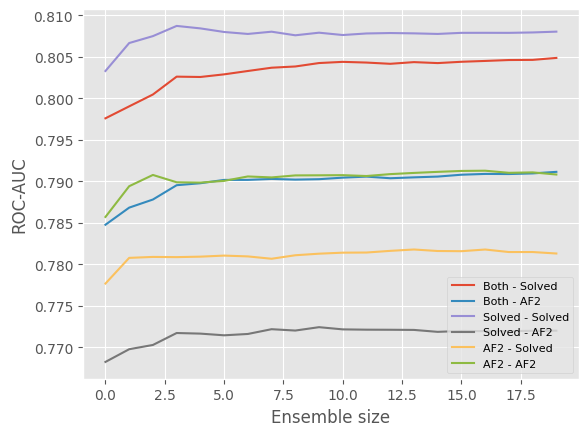

In [33]:
# Using the style for the plot
plt.style.use('ggplot')

# Plot ensemble curve
plt.plot(ROC_AUC_both_solved, label = 'Both - Solved')
plt.plot(ROC_AUC_both_af2, label = 'Both - AF2')
plt.plot(ROC_AUC_solved_solved, label = 'Solved - Solved')
plt.plot(ROC_AUC_solved_af2, label = 'Solved - AF2')
plt.plot(ROC_AUC_af2_solved, label = 'AF2 - Solved')
plt.plot(ROC_AUC_af2_af2, label = 'AF2 - AF2')

plt.ylabel('ROC-AUC')
plt.xlabel('Ensemble size')
plt.legend(loc='lower right', fontsize = 8)
plt.savefig('10NN_ensemble.png', format='png', dpi=1200, facecolor='white', bbox_inches='tight')

In [39]:
print('Ensemble results for structure of 10 hidden units: \n')
print('Solved - Solved:', str(ROC_AUC_solved_solved[-1]))
print('Both - Solved:\t', str(ROC_AUC_both_solved[-1]))
print('AF2 - AF2:\t', str(ROC_AUC_af2_af2[-1]))
print('Both - AF2:\t', str(ROC_AUC_both_af2[-1]))
print('AF2 - Solved:\t', str(ROC_AUC_af2_solved[-1]))
print('Solved - AF2:\t', str(ROC_AUC_solved_af2[-1]))

Ensemble results for structure of 10 hidden units: 

Solved - Solved: 0.8080206872893237
Both - Solved:	 0.8048532547174996
AF2 - AF2:	 0.790806264983821
Both - AF2:	 0.7911271601429968
AF2 - Solved:	 0.781288408429719
Solved - AF2:	 0.7719932210720997
